In [1]:
from google.colab import drive
drive.mount('/content/drive/')
from collections import defaultdict
import copy
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image, ImageDraw
import os
import re
from scipy.stats import entropy
import seaborn as sns
from sklearn.metrics import top_k_accuracy_score, accuracy_score, f1_score
import sys
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.quantization as tq
from torch.ao.quantization.quantize_fx import prepare_qat_fx
from torch.ao.quantization.qconfig_mapping import QConfigMapping
from torchvision.models import vgg16, resnet18, squeezenet1_1
from tqdm import tqdm
import random

Mounted at /content/drive/


In [2]:
easy_quant_dir = "/content/drive/MyDrive/Thesis/EasyQuant/"
sys.path.append(easy_quant_dir)
from quant_modules.state_toggling import (
    enable_fake_quant,
    enable_PTQ_observer,
    disable_fake_quant,
    disable_PTQ_observer,
)
from quant_modules.learnable_fake_quantize import (
    EQLearnableFakeQuantize
)

In [3]:
IMG_DIR = "/content/drive/MyDrive/Thesis/fgvc/test_images"
IMG_ROOT = "/content/drive/MyDrive/Thesis/fgvc/"
BBOX_FILE = "/content/drive/MyDrive/Thesis/fgvc/images_box.txt"
ANNOTATIONS_FILE = "/content/drive/MyDrive/Thesis/fgvc/images_family_test.txt"
results_dir = "/content/drive/MyDrive/ResultsDec22/"

### OLD IGNORE

In [ ]:
class BaseDataset(Dataset):
    def __init__(self, images_dir, annotations_file, N=None, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.img_labels = []
        self.label_to_idx = {}
        self.idx_to_label = {}
        idx_counter = 0
        with open(annotations_file, "r") as file:
            for line in file:
                img_name, label = line.strip().split(" ", 1)
                if label not in self.label_to_idx:
                    self.label_to_idx[label] = idx_counter
                    self.idx_to_label[idx_counter] = label
                    idx_counter += 1
                self.img_labels.append((img_name, self.label_to_idx[label]))
                if N is not None and len(self.img_labels) >= N:
                    break

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name, label_idx = self.img_labels[idx]
        img_path = os.path.join(self.images_dir, f"{img_name}.jpg")
        image = Image.open(img_path)
        image = image.crop((0, 0, image.width, image.height - 20))

        image = self.transform(image)
        label_tensor = torch.tensor(label_idx, dtype=torch.long)
        return image, label_tensor

class AddVerticalStreaks:
    def __init__(self, num_streaks=5):
        """
        Transform to add evenly spaced vertical black streaks to an image tensor.

        Args:
            num_streaks (int): Number of vertical streaks to add.
        """
        self.num_streaks = num_streaks

    def __call__(self, tensor):
        _, height, width = tensor.shape
        streak_width = width // 50
        total_streak_width = streak_width * self.num_streaks
        remaining_width = width - total_streak_width
        spacing = remaining_width // (self.num_streaks + 1)
        black = torch.tensor([-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225]).view(-1, 1, 1)

        # Add vertical streaks
        for i in range(self.num_streaks):
            start_x = spacing * (i + 1) + streak_width * i
            end_x = start_x + streak_width
            tensor[:, :, start_x:end_x] = black

        return tensor

class AddHorizontalStreaks:
    def __init__(self, num_streaks=5):
        """
        Transform to add evenly spaced horizontal black streaks to an image tensor.

        Args:
            num_streaks (int): Number of horizontal streaks to add.
        """
        self.num_streaks = num_streaks

    def __call__(self, tensor):
        _, height, width = tensor.shape
        streak_height = height // 50  # Fixed height for streaks
        total_streak_height = streak_height * self.num_streaks
        remaining_height = height - total_streak_height
        spacing = remaining_height // (self.num_streaks + 1)
        black = torch.tensor([-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225]).view(-1, 1, 1)

        # Add horizontal streaks
        for i in range(self.num_streaks):
            start_y = spacing * (i + 1) + streak_height * i
            end_y = start_y + streak_height
            tensor[:, start_y:end_y, :] = black

        return tensor

class AddGaussianNoise:
    def __init__(self, std):
        self.std = std
    def __call__(self, image):
        noise = torch.randn_like(image) * self.std
        noisy_image = image + noise
        return torch.clamp(noisy_image, 0, 1)

class AddBrownianNoise:
    def __init__(self, std):
        self.std = std
        self.freq_grid_cache = None

    def _create_freq_grid(self, shape):
        freqs = [torch.fft.fftfreq(n, d=1.0 / n) for n in shape]
        u, v = torch.meshgrid(freqs[0], freqs[1], indexing="ij")
        f = torch.sqrt(u**2 + v**2)
        f[0, 0] = 1.0  # Avoid division by zero for DC component
        return 1 / (f ** 2)

    def _generate_brownian_noise(self, image):
        # Generate white noise
        white_noise = torch.randn_like(image) * self.std

        # Cache the frequency grid if not already cached or if shape changes
        if self.freq_grid_cache is None or self.freq_grid_cache.shape[-2:] != image.shape[-2:]:
            self.freq_grid_cache = self._create_freq_grid(image.shape[-2:]).to(image.device)

        # Apply frequency-domain filtering
        noise_fft = torch.fft.fftn(white_noise, dim=(-2, -1))
        noise_fft *= self.freq_grid_cache.unsqueeze(0)  # Apply 1/f^2 scaling per channel
        brownian_noise = torch.fft.ifftn(noise_fft, dim=(-2, -1)).real

        return brownian_noise

    def __call__(self, image):
        brownian_noise = self._generate_brownian_noise(image)
        noisy_image = image + brownian_noise
        return torch.clamp(noisy_image, 0, 1)  # Clamp to valid range

# OLD
brownian_std = 50
awgn_std = 0.4

base_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])
                                     ])

base_dataset = BaseDataset(IMG_DIR, ANNOTATIONS_FILE, transform=base_transform)
base_loader = DataLoader(base_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)



vert_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225]),
                                     AddVerticalStreaks(num_streaks=5)
                                     ])
vert_dataset = BaseDataset(IMG_DIR, ANNOTATIONS_FILE, transform=vert_transform)
vert_loader = DataLoader(vert_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)


horiz_transform = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225]),
                                      AddHorizontalStreaks(num_streaks=5)
                                      ])
horiz_dataset = BaseDataset(IMG_DIR, ANNOTATIONS_FILE, transform=horiz_transform)
horiz_loader = DataLoader(horiz_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)


awgn_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     AddGaussianNoise(std=awgn_std),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])
                                     ])
awgn_dataset = BaseDataset(IMG_DIR, ANNOTATIONS_FILE, transform=awgn_transform)
awgn_loader = DataLoader(awgn_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)


brown_transform = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      AddBrownianNoise(std=brownian_std),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])
                                      ])
brown_dataset = BaseDataset(IMG_DIR, ANNOTATIONS_FILE, transform=brown_transform)
brown_loader = DataLoader(brown_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

### END OLD

In [4]:
class BaseDataset(Dataset):
    def __init__(self, images_dir, annotations_file, N=None, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.img_labels = []
        self.label_to_idx = {}
        self.idx_to_label = {}
        idx_counter = 0
        with open(annotations_file, "r") as file:
            for line in file:
                img_name, label = line.strip().split(" ", 1)
                if label not in self.label_to_idx:
                    self.label_to_idx[label] = idx_counter
                    self.idx_to_label[idx_counter] = label
                    idx_counter += 1
                self.img_labels.append((img_name, self.label_to_idx[label]))
                if N is not None and len(self.img_labels) >= N:
                    break

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name, label_idx = self.img_labels[idx]
        img_path = os.path.join(self.images_dir, f"{img_name}.jpg")
        image = Image.open(img_path)
        image = image.crop((0, 0, image.width, image.height - 20))
        to_tensor_transform = transforms.ToTensor()
        image = to_tensor_transform(image)

        image = self.transform(image)
        label_tensor = torch.tensor(label_idx, dtype=torch.long)
        return image, label_tensor


class BaseNoiseDataset(Dataset):
    def __init__(self, images_dir, annotations_file, transform, N=None):
        self.images_dir = images_dir
        self.transform = transform
        self.img_labels = []
        self.label_to_idx = {}
        self.idx_to_label = {}
        idx_counter = 0
        with open(annotations_file, "r") as file:
            for line in file:
                img_name, label = line.strip().split(" ", 1)
                if label not in self.label_to_idx:
                    self.label_to_idx[label] = idx_counter
                    self.idx_to_label[idx_counter] = label
                    idx_counter += 1
                self.img_labels.append((img_name, self.label_to_idx[label]))
                if N is not None and len(self.img_labels) >= N:
                    break

    def __len__(self):
        return len(self.img_labels)

    def _load_image(self, img_path):
        image = Image.open(img_path)
        image = image.crop((0, 0, image.width, image.height - 20))
        return transforms.ToTensor()(image)

    def _apply_noise(self, image):
        raise NotImplementedError

    def __getitem__(self, idx):
        img_name, label_idx = self.img_labels[idx]
        img_path = os.path.join(self.images_dir, f"{img_name}.jpg")
        image = self._load_image(img_path)
        image = self._apply_noise(image)
        image = self.transform(image)
        label_tensor = torch.tensor(label_idx, dtype=torch.long)
        return image, label_tensor

class AWGNDataset(BaseNoiseDataset):
    def __init__(self, images_dir, annotations_file, sigma, transform, N=None):
        super().__init__(images_dir, annotations_file, transform, N)
        self.sigma = sigma

    def _apply_noise(self, image):
        noise = torch.randn_like(image) * self.sigma
        noisy_image = image + noise
        return torch.clamp(noisy_image, 0, 1)

class BrownianNoiseDataset(BaseNoiseDataset):
    def __init__(self, images_dir, annotations_file, sigma, transform, N=None):
        super().__init__(images_dir, annotations_file, transform, N)
        self.sigma = sigma
        self.freq_grid = None

    def _create_freq_grid(self, shape):
        freqs = [torch.fft.fftfreq(n, d=1.0 / n) for n in shape]
        u, v = torch.meshgrid(freqs[0], freqs[1], indexing="ij")
        f = torch.sqrt(u**2 + v**2)
        f[0, 0] = 1.0  # Avoid division by zero
        return 1 / (f ** 2)

    def _apply_noise(self, image):
        if self.freq_grid is None or self.freq_grid.shape != image.shape[1:]:
            self.freq_grid = self._create_freq_grid(image.shape[1:]).to(image.device)

        white_noise = torch.randn_like(image) * self.sigma
        noise_fft = torch.fft.fftn(white_noise, dim=(-2, -1))
        noise_fft *= self.freq_grid.unsqueeze(0)
        brownian_noise = torch.fft.ifftn(noise_fft, dim=(-2, -1)).real

        noisy_image = image + brownian_noise
        return torch.clamp(noisy_image, 0, 1)

class VerticalStreaksDataset(BaseDataset):
    def __init__(
        self, images_dir, annotations_file, bbox_file, num_streaks, transform=None, N=None
    ):
        super().__init__(images_dir, annotations_file, N, transform)
        self.bboxes = self.load_bboxes(bbox_file)
        self.num_streaks = num_streaks

    def load_bboxes(self, bbox_file):
        bboxes = {}
        with open(bbox_file, "r") as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) == 5:
                    img_id, x1, y1, x2, y2 = parts
                    bboxes[img_id] = (int(x1), int(y1), int(x2), int(y2))
        return bboxes
    def __getitem__(self, idx):
        img_name, label_idx = self.img_labels[idx]
        img_path = os.path.join(self.images_dir, f"{img_name}.jpg")
        img = Image.open(img_path).convert("RGB")
        if img_name in self.bboxes:
            x1, y1, x2, y2 = self.bboxes[img_name]
            width = x2 - x1
            height = y2 - y1
            streak_width = width // 50
            total_streak_width = streak_width * self.num_streaks
            remaining_width = width - total_streak_width
            spacing = remaining_width / (self.num_streaks + 1)

            current_x = x1 + spacing
            for _ in range(self.num_streaks):
                img.paste(
                    Image.new("RGB", (streak_width, height), (0, 0, 0)),
                    (int(current_x), y1),
                )
                current_x += streak_width + spacing
        img = img.crop((0, 0, img.width, img.height - 20))
        to_tensor_transform = transforms.ToTensor()
        img = to_tensor_transform(img)

        if self.transform:
            img = self.transform(img)

        return img, label_idx

class HorizontalStreaksDataset(BaseDataset):
    def __init__(
        self, images_dir, annotations_file, bbox_file, num_streaks, transform=None, N=None
    ):
        super().__init__(images_dir, annotations_file, N, transform)
        self.bboxes = self.load_bboxes(bbox_file)
        self.num_streaks = num_streaks

    def load_bboxes(self, bbox_file):
        bboxes = {}
        with open(bbox_file, "r") as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) == 5:
                    img_id, x1, y1, x2, y2 = parts
                    bboxes[img_id] = (int(x1), int(y1), int(x2), int(y2))
        return bboxes

    def __getitem__(self, idx):
        img_name, label_idx = self.img_labels[idx]
        img_path = os.path.join(self.images_dir, f"{img_name}.jpg")
        img = Image.open(img_path).convert("RGB")

        # Apply horizontal black streaks within bounding box
        if img_name in self.bboxes:
            x1, y1, x2, y2 = self.bboxes[img_name]
            width = x2 - x1
            height = y2 - y1

            # Fixed streak height
            streak_height = height // 50  # You can adjust this value to change the base streak height

            # Calculate total height of all streaks
            total_streak_height = streak_height * self.num_streaks

            # Calculate remaining height for spacing
            remaining_height = height - total_streak_height

            # Calculate spacing between streaks
            spacing = remaining_height / (self.num_streaks + 1)

            current_y = y1 + spacing
            for _ in range(self.num_streaks):
                img.paste(
                    Image.new("RGB", (width, streak_height), (0, 0, 0)),
                    (x1, int(current_y)),
                )
                current_y += streak_height + spacing

        img = img.crop((0, 0, img.width, img.height - 20))

        to_tensor_transform = transforms.ToTensor()
        img = to_tensor_transform(img)

        if self.transform:
            img = self.transform(img)

        return img, label_idx

In [99]:
def show_samples(datasets):
    # Calculate layout dimensions
    n_datasets = len(datasets)
    n_cols = min(3, n_datasets)  # Maximum 3 columns
    n_rows = (n_datasets + n_cols - 1) // n_cols  # Ceiling division for number of rows

    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_datasets == 1:
        axes = np.array([axes])  # Convert single axis to array for consistent indexing
    axes = axes.flatten()  # Flatten axes array for easier indexing

    # Hide unused subplots
    for idx in range(n_datasets, len(axes)):
        axes[idx].axis('off')

    for idx, (dataset, ax) in enumerate(zip(datasets, axes)):
        # Randomly select a sample
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        image, label = dataset[sample_idx]

        # Reverse normalization
        if isinstance(image, torch.Tensor):
            unnormalize = transforms.Normalize(
                mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
            )
            image = unnormalize(image)  # Apply unnormalization
            image = torch.clamp(image, 0, 1)  # Ensure valid pixel values
            image = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C) format

        # Get the class name
        class_name = dataset.idx_to_label[int(label)]

        # Display the image
        # Save the image
        plt.imsave(f"image_{class_name}.jpg", image)
        ax.imshow(image)
        ax.axis("off")
        print(class_name)

    plt.tight_layout()
    plt.show()

Tornado


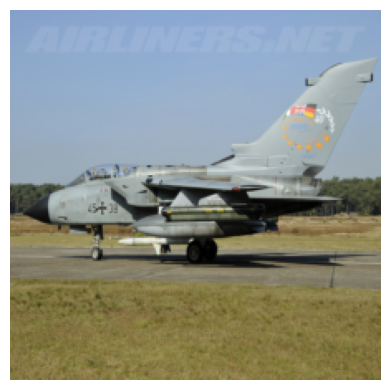

Saab 2000


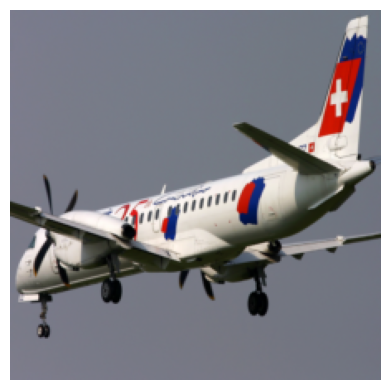

A330


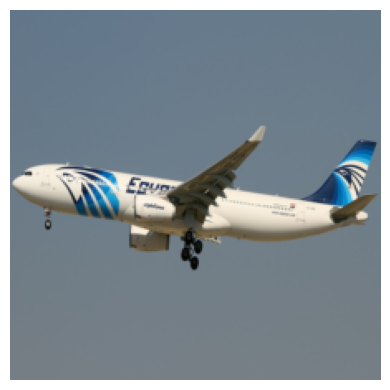

Dornier 328


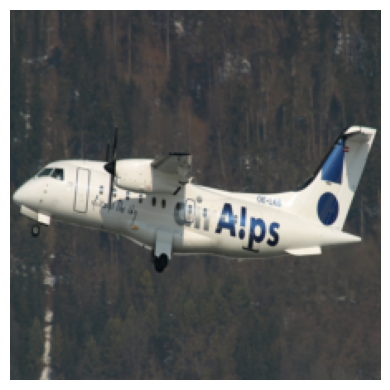

In [105]:
transform = transforms.Compose([transforms.Resize((224, 224)),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
num_workers = 2
b_size = 128

base_dataset = BaseDataset(IMG_DIR, ANNOTATIONS_FILE, transform=transform, N=None)
awgn_dataset = AWGNDataset(IMG_DIR, ANNOTATIONS_FILE, sigma=0.5, transform=transform, N=None)
brownian_dataset = BrownianNoiseDataset(IMG_DIR, ANNOTATIONS_FILE, sigma=40, transform=transform, N=None)

vert_dataset = VerticalStreaksDataset(IMG_DIR, ANNOTATIONS_FILE, BBOX_FILE, num_streaks=3, transform=transform, N=None)
horiz_dataset = HorizontalStreaksDataset(IMG_DIR, ANNOTATIONS_FILE, BBOX_FILE, num_streaks=3, transform=transform, N=None)

show_samples([base_dataset])
show_samples([base_dataset])
show_samples([base_dataset])
show_samples([base_dataset])




In [6]:
def quantize(model):
  learnable_weight = lambda channels: EQLearnableFakeQuantize.with_args(
      observer=tq.PerChannelMinMaxObserver,
      quant_min=-128,
      quant_max=127,
      dtype=torch.qint8,
      qscheme=torch.per_channel_symmetric,
      scale=0.1,
      zero_point=0.0,
      use_grad_scaling=True,
      channel_len=channels,
  )

  learnable_act = EQLearnableFakeQuantize.with_args(
      observer=tq.HistogramObserver,
      quant_min=0,
      quant_max=255,
      dtype=torch.quint8,
      qscheme=torch.per_tensor_affine,
      scale=1.0,
      zero_point=0.0,
      use_grad_scaling=True,
  )
  torch.backends.quantized.engine = "qnnpack"
  qconfig_mapping = QConfigMapping()

  for name, module in model.named_modules():
      if hasattr(module, "out_channels"):
          qconfig = tq.QConfig(
              activation=learnable_act,
              weight=learnable_weight(channels=module.out_channels),
          )
          qconfig_mapping.set_module_name(name, qconfig)
          module.qconfig = qconfig
  example_inputs = (torch.randn(1, 3, 224, 224),)
  model.eval()
  fx_model = prepare_qat_fx(model, qconfig_mapping, example_inputs)
  fx_model.eval()
  _ = fx_model.apply(enable_fake_quant)
  _ = fx_model.apply(enable_PTQ_observer)

  print("\nFX Model prepared")
  fx_model.apply(enable_PTQ_observer)

  return fx_model

In [ ]:
resnet18_fp = resnet18(weights=None)
vgg16_fp = vgg16(weights=None)
squeezenet1_1_fp = squeezenet1_1(weights=None)

num_ftrs = resnet18_fp.fc.in_features
resnet18_fp.fc = torch.nn.Linear(num_ftrs, 70)

num_ftrs = vgg16_fp.classifier[6].in_features
vgg16_fp.classifier[6] = torch.nn.Linear(num_ftrs, 70)

squeezenet1_1_fp.classifier[1] = torch.nn.Conv2d(512, 70, kernel_size=(1,1), stride=(1,1))
squeezenet1_1_fp.num_classes = 70

resnet18_fp.load_state_dict(torch.load("/content/drive/MyDrive/Thesis/models/resnet18.pth", map_location="cpu"))
vgg16_fp.load_state_dict(torch.load("/content/drive/MyDrive/Thesis/models/vgg16.pth", map_location="cpu"))
squeezenet1_1_fp.load_state_dict(torch.load("/content/drive/MyDrive/Thesis/models/squeezenet1_1.pth", map_location="cpu"))

<ipython-input-22-c76d55c6f3a3>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet18_fp.load_state_dict(torch.load("/content/drive/MyDrive/Thesis/models/resnet18.pth",

<All keys matched successfully>

In [ ]:
resnet18_int8 = quantize(resnet18_fp)
squeezenet1_1_int8 = quantize(squeezenet1_1_fp)
vgg16_int8 = quantize(vgg16_fp)


FX Model prepared

FX Model prepared

FX Model prepared


In [ ]:
def evaluate(model, loader, device):
    model.eval()
    model.to(device)
    preds = []
    true_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels_batch in tqdm(loader, desc="Evaluating"):
            images = images.to(device)
            labels_batch = labels_batch.to(device)
            true_labels.extend(labels_batch.cpu().numpy())
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            preds.extend(torch.argmax(probs, dim=1).cpu().numpy())

    true_labels = np.array(true_labels)
    preds = np.array(preds)
    all_probs = np.array(all_probs)

    top1_accuracy = accuracy_score(true_labels, preds)
    top5_accuracy = top_k_accuracy_score(true_labels, all_probs, k=5)
    f1 = f1_score(true_labels, preds, average='weighted')

    print(f"Evaluation results: Top-1 Accuracy: {top1_accuracy:.4f}, Top-5 Accuracy: {top5_accuracy:.4f}, F1 Score: {f1:.4f}")

    return {
        "top1_accuracy": top1_accuracy,
        "top5_accuracy": top5_accuracy,
        "f1_score": f1,
        "probabilities": all_probs.tolist(),
        "true_labels": true_labels.tolist(),
        "predictions": preds.tolist()
    }

In [ ]:
transform = transforms.Compose([transforms.Resize((224, 224)),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
num_workers = 2
b_size = 128
N = None
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results_dir = "/content/drive/MyDrive/ResultsDec28"
os.makedirs(results_dir, exist_ok=True)

models = [
    ("resnet18_fp", resnet18_fp, 0),
    ("vgg16_fp", vgg16_fp, 0),
    ("squeezenet1_1_fp", squeezenet1_1_fp, 0),
    ("resnet18_int8", resnet18_int8, 1),
    ("vgg16_int8", vgg16_int8, 1),
    ("squeezenet1_1_int8", squeezenet1_1_int8, 1)
]

num_streaks = [1]
for model in models:
  for num in num_streaks:

    model_name, model_obj, device_type = model
    device = "cuda" if device_type == 0 else "cpu"
    pin_memory = True if device == "cuda" else False
    print(f"Evaluating {model_name} on {device}...")


    print(f"Number of streaks: {num}\n")
    vert_dataset = VerticalStreaksDataset(IMG_DIR, ANNOTATIONS_FILE, BBOX_FILE, num_streaks=num, transform=transform, N=None)
    vert_loader = DataLoader(vert_dataset, batch_size=b_size, num_workers=2, pin_memory=pin_memory, shuffle=False)

    # Evaluate the model
    results_vert = evaluate(model_obj, vert_loader, device=device)

    # Save results to a JSON file
    results_file = os.path.join(results_dir, f"{model_name}_{num}_vert_streaks_results.json")
    with open(results_file, "w") as f:
        json.dump(results_vert, f, indent=4)

    print(f"Results saved to {results_file}")

for model in models:
  for num in num_streaks:
    print(f"Number of streaks: {num}\n")

    model_name, model_obj, device_type = model
    device = "cuda" if device_type == 0 else "cpu"
    pin_memory = True if device == "cuda" else False
    print(f"Evaluating {model_name} on {device}...")
    horiz_dataset = HorizontalStreaksDataset(IMG_DIR, ANNOTATIONS_FILE, BBOX_FILE, num_streaks=num, transform=transform, N=None)
    horiz_loader = DataLoader(horiz_dataset, batch_size=b_size, num_workers=2, pin_memory=pin_memory, shuffle=False)

    # Evaluate the model
    results_horiz = evaluate(model_obj, horiz_loader, device=device)

    # Save results to a JSON file
    results_file = os.path.join(results_dir, f"{model_name}_{num}_horiz_streaks_results.json")
    with open(results_file, "w") as f:
        json.dump(results_horiz, f, indent=4)

    print(f"Results saved to {results_file}")

### Plotting

In [7]:
awgn_dir = "/content/drive/MyDrive/paperV4/data/awgn"
brownian_dir = "/content/drive/MyDrive/paperV4/data/brownian"
horiz_streaks_dir = "/content/drive/MyDrive/paperV4/data/horiz_streaks"
vert_streaks_dir = "/content/drive/MyDrive/paperV4/data/vert_streaks"

In [8]:
# open json file
awgn_sigmas = [0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0]
brownian_sigmas = [10,20,30,40,50,60,70,80]
num_streaks = [1,2,3,4,5,6]

def extract_results(model_name, intensities, direc, noise_type):
  fp_top1_accuracies = {}
  int8_top1_accuracies = {}
  fp_top5_accuracies = {}
  int8_top5_accuracies = {}
  fp_f1 = {}
  int8_f1 = {}
  fp_probabilities = {}
  int8_probabilities = {}



  for intensity in intensities:
    if noise_type == "awgn":
      fp_file_name = direc + f"/{model_name}_fp_{intensity}_{noise_type}.json"
      int8_file_name = direc + f"/{model_name}_int8_{intensity}_{noise_type}.json"
    else:
      fp_file_name = direc + f"/{model_name}_fp_{intensity}_{noise_type}_results.json"
      int8_file_name = direc + f"/{model_name}_int8_{intensity}_{noise_type}_results.json"
    with open(fp_file_name, "r") as fp_file:
      fp_data = json.load(fp_file)
    with open(int8_file_name, "r") as int8_file:
      int8_data = json.load(int8_file)

    fp_top1_accuracies[intensity] = fp_data["top1_accuracy"]
    int8_top1_accuracies[intensity] = int8_data["top1_accuracy"]
    fp_top5_accuracies[intensity] = fp_data["top5_accuracy"]
    int8_top5_accuracies[intensity] = int8_data["top5_accuracy"]
    fp_f1[intensity] = fp_data["f1_score"]
    int8_f1[intensity] = int8_data["f1_score"]
    fp_probabilities[intensity] = fp_data["probabilities"]
    int8_probabilities[intensity] = int8_data["probabilities"]
  return (fp_top1_accuracies, int8_top1_accuracies, fp_top5_accuracies, int8_top5_accuracies, fp_f1, int8_f1, fp_probabilities, int8_probabilities)


In [9]:
awgn_results_resnet18 = extract_results("resnet18", awgn_sigmas, awgn_dir, "awgn")
awgn_results_vgg16 = extract_results("vgg16", awgn_sigmas, awgn_dir, "awgn")
awgn_results_squeezenet1_1 = extract_results("squeezenet1_1", awgn_sigmas, awgn_dir, "awgn")

brownian_results_resnet18 = extract_results("resnet18", brownian_sigmas, brownian_dir, "brownian")
brownian_results_vgg16 = extract_results("vgg16", brownian_sigmas, brownian_dir, "brownian")
brownian_results_squeezenet1_1 = extract_results("squeezenet1_1", brownian_sigmas, brownian_dir, "brownian")

horiz_results_resnet18 = extract_results("resnet18", num_streaks, horiz_streaks_dir, "horiz_streaks")
horiz_results_vgg16 = extract_results("vgg16", num_streaks, horiz_streaks_dir, "horiz_streaks")
horiz_results_squeezenet1_1 = extract_results("squeezenet1_1", num_streaks, horiz_streaks_dir, "horiz_streaks")

vert_results_resnet18 = extract_results("resnet18", num_streaks, vert_streaks_dir, "vert_streaks")
vert_results_vgg16 = extract_results("vgg16", num_streaks, vert_streaks_dir, "vert_streaks")
vert_results_squeezenet1_1 = extract_results("squeezenet1_1", num_streaks, vert_streaks_dir, "vert_streaks")

In [10]:
# AWGN
resnet18_fp_awgn_top1 = awgn_results_resnet18[0]
resnet18_int8_awgn_top1 = awgn_results_resnet18[1]
resnet18_fp_awgn_top5 = awgn_results_resnet18[2]
resnet18_int8_awgn_top5 = awgn_results_resnet18[3]
resnet18_fp_awgn_f1 = awgn_results_resnet18[4]
resnet18_int8_awgn_f1 = awgn_results_resnet18[5]
resnet18_fp_awgn_probs = awgn_results_resnet18[6]
resnet18_int8_awgn_probs = awgn_results_resnet18[7]

vgg16_fp_awgn_top1 = awgn_results_vgg16[0]
vgg16_int8_awgn_top1 = awgn_results_vgg16[1]
vgg16_fp_awgn_top5 = awgn_results_vgg16[2]
vgg16_int8_awgn_top5 = awgn_results_vgg16[3]
vgg16_fp_awgn_f1 = awgn_results_vgg16[4]
vgg16_int8_awgn_f1 = awgn_results_vgg16[5]
vgg16_fp_awgn_probs = awgn_results_vgg16[6]
vgg16_int8_awgn_probs = awgn_results_vgg16[7]

squeezenet1_1_fp_awgn_top1 = awgn_results_squeezenet1_1[0]
squeezenet1_1_int8_awgn_top1 = awgn_results_squeezenet1_1[1]
squeezenet1_1_fp_awgn_top5 = awgn_results_squeezenet1_1[2]
squeezenet1_1_int8_awgn_top5 = awgn_results_squeezenet1_1[3]
squeezenet1_1_fp_awgn_f1 = awgn_results_squeezenet1_1[4]
squeezenet1_1_int8_awgn_f1 = awgn_results_squeezenet1_1[5]
squeezenet1_1_fp_awgn_probs = awgn_results_squeezenet1_1[6]
squeezenet1_1_int8_awgn_probs = awgn_results_squeezenet1_1[7]

# Brownian
resnet18_fp_brownian_top1 = brownian_results_resnet18[0]
resnet18_int8_brownian_top1 = brownian_results_resnet18[1]
resnet18_fp_brownian_top5 = brownian_results_resnet18[2]
resnet18_int8_brownian_top5 = brownian_results_resnet18[3]
resnet18_fp_brownian_f1 = brownian_results_resnet18[4]
resnet18_int8_brownian_f1 = brownian_results_resnet18[5]
resnet18_fp_brownian_probs = brownian_results_resnet18[6]
resnet18_int8_brownian_probs = brownian_results_resnet18[7]

vgg16_fp_brownian_top1 = brownian_results_vgg16[0]
vgg16_int8_brownian_top1 = brownian_results_vgg16[1]
vgg16_fp_brownian_top5 = brownian_results_vgg16[2]
vgg16_int8_brownian_top5 = brownian_results_vgg16[3]
vgg16_fp_brownian_f1 = brownian_results_vgg16[4]
vgg16_int8_brownian_f1 = brownian_results_vgg16[5]
vgg16_fp_brownian_probs = brownian_results_vgg16[6]
vgg16_int8_brownian_probs = brownian_results_vgg16[7]

squeezenet1_1_fp_brownian_top1 = brownian_results_squeezenet1_1[0]
squeezenet1_1_int8_brownian_top1 = brownian_results_squeezenet1_1[1]
squeezenet1_1_fp_brownian_top5 = brownian_results_squeezenet1_1[2]
squeezenet1_1_int8_brownian_top5 = brownian_results_squeezenet1_1[3]
squeezenet1_1_fp_brownian_f1 = brownian_results_squeezenet1_1[4]
squeezenet1_1_int8_brownian_f1 = brownian_results_squeezenet1_1[5]
squeezenet1_1_fp_brownian_probs = brownian_results_squeezenet1_1[6]
squeezenet1_1_int8_brownian_probs = brownian_results_squeezenet1_1[7]

# Vertical Streaks
resnet18_fp_vert_top1 = vert_results_resnet18[0]
resnet18_int8_vert_top1 = vert_results_resnet18[1]
resnet18_fp_vert_top5 = vert_results_resnet18[2]
resnet18_int8_vert_top5 = vert_results_resnet18[3]
resnet18_fp_vert_f1 = vert_results_resnet18[4]
resnet18_int8_vert_f1 = vert_results_resnet18[5]
resnet18_fp_vert_probs = vert_results_resnet18[6]
resnet18_int8_vert_probs = vert_results_resnet18[7]

vgg16_fp_vert_top1 = vert_results_vgg16[0]
vgg16_int8_vert_top1 = vert_results_vgg16[1]
vgg16_fp_vert_top5 = vert_results_vgg16[2]
vgg16_int8_vert_top5 = vert_results_vgg16[3]
vgg16_fp_vert_f1 = vert_results_vgg16[4]
vgg16_int8_vert_f1 = vert_results_vgg16[5]
vgg16_fp_vert_probs = vert_results_vgg16[6]
vgg16_int8_vert_probs = vert_results_vgg16[7]

squeezenet1_1_fp_vert_top1 = vert_results_squeezenet1_1[0]
squeezenet1_1_int8_vert_top1 = vert_results_squeezenet1_1[1]
squeezenet1_1_fp_vert_top5 = vert_results_squeezenet1_1[2]
squeezenet1_1_int8_vert_top5 = vert_results_squeezenet1_1[3]
squeezenet1_1_fp_vert_f1 = vert_results_squeezenet1_1[4]
squeezenet1_1_int8_vert_f1 = vert_results_squeezenet1_1[5]
squeezenet1_1_fp_vert_probs = vert_results_squeezenet1_1[6]
squeezenet1_1_int8_vert_probs = vert_results_squeezenet1_1[7]

# Horizontal Streaks
resnet18_fp_horiz_top1 = horiz_results_resnet18[0]
resnet18_int8_horiz_top1 = horiz_results_resnet18[1]
resnet18_fp_horiz_top5 = horiz_results_resnet18[2]
resnet18_int8_horiz_top5 = horiz_results_resnet18[3]
resnet18_fp_horiz_f1 = horiz_results_resnet18[4]
resnet18_int8_horiz_f1 = horiz_results_resnet18[5]
resnet18_fp_horiz_probs = horiz_results_resnet18[6]
resnet18_int8_horiz_probs = horiz_results_resnet18[7]

vgg16_fp_horiz_top1 = horiz_results_vgg16[0]
vgg16_int8_horiz_top1 = horiz_results_vgg16[1]
vgg16_fp_horiz_top5 = horiz_results_vgg16[2]
vgg16_int8_horiz_top5 = horiz_results_vgg16[3]
vgg16_fp_horiz_f1 = horiz_results_vgg16[4]
vgg16_int8_horiz_f1 = horiz_results_vgg16[5]
vgg16_fp_horiz_probs = horiz_results_vgg16[6]
vgg16_int8_horiz_probs = horiz_results_vgg16[7]

squeezenet1_1_fp_horiz_top1 = horiz_results_squeezenet1_1[0]
squeezenet1_1_int8_horiz_top1 = horiz_results_squeezenet1_1[1]
squeezenet1_1_fp_horiz_top5 = horiz_results_squeezenet1_1[2]
squeezenet1_1_int8_horiz_top5 = horiz_results_squeezenet1_1[3]
squeezenet1_1_fp_horiz_f1 = horiz_results_squeezenet1_1[4]
squeezenet1_1_int8_horiz_f1 = horiz_results_squeezenet1_1[5]
squeezenet1_1_fp_horiz_probs = horiz_results_squeezenet1_1[6]
squeezenet1_1_int8_horiz_probs = horiz_results_squeezenet1_1[7]

In [ ]:
# Output for LaTex table

awgn_sigmas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0]
brownian_sigmas = [10,20,30,40,50,60,70,80]
num_streaks = [1,2,3,4,5,6]

# Loop and print
awgn_sigmas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0]
i = 0
for sigma in num_streaks:
    top1_sn_fp = squeezenet1_1_fp_horiz_top1[sigma]
    top1_sn_int8 = squeezenet1_1_int8_horiz_top1[sigma]
    top1_rn_fp = resnet18_fp_horiz_top1[sigma]
    top1_rn_int8 = resnet18_int8_horiz_top1[sigma]
    top1_vn_fp = vgg16_fp_horiz_top1[sigma]
    top1_vn_int8 = vgg16_int8_horiz_top1[sigma]

    top5_sn_fp = squeezenet1_1_fp_horiz_top5[sigma]
    top5_sn_int8 = squeezenet1_1_int8_horiz_top5[sigma]
    top5_rn_fp = resnet18_fp_horiz_top5[sigma]
    top5_rn_int8 = resnet18_int8_horiz_top5[sigma]
    top5_vn_fp = vgg16_fp_horiz_top5[sigma]
    top5_vn_int8 = vgg16_int8_horiz_top5[sigma]

    f1_sn_fp = squeezenet1_1_fp_horiz_f1[sigma]
    f1_sn_int8 = squeezenet1_1_int8_horiz_f1[sigma]
    f1_rn_fp = resnet18_fp_horiz_f1[sigma]
    f1_rn_int8 = resnet18_int8_horiz_f1[sigma]
    f1_vn_fp = vgg16_fp_horiz_f1[sigma]
    f1_vn_int8 = vgg16_int8_horiz_f1[sigma]




    print(str(sigma) + "&\n"
    "\\multicolumn{1}{l|}{" + f"{top1_sn_fp:.3f}" + "}&\n\\multicolumn{1}{l|}{" + f"{top1_sn_int8:.3f}" + "}&\n\\multicolumn{1}{l|}{" + f"{top1_rn_fp:.3f}" + "}&\n\\multicolumn{1}{l|}{" + f"{top1_rn_int8:.3f}" + "}&\n\\multicolumn{1}{l|}{" + f"{top1_vn_fp:.3f}" + "}&\n"
    +f"{top1_vn_int8:.3f}&"
    +
    "\n\\multicolumn{1}{l|}{" + f"{top5_sn_fp:.3f}" + "}&\n\\multicolumn{1}{l|}{" + f"{top5_sn_int8:.3f}" + "}&\n\\multicolumn{1}{l|}{" + f"{top5_rn_fp:.3f}" + "}&\n\\multicolumn{1}{l|}{" + f"{top5_rn_int8:.3f}" + "}&\n\\multicolumn{1}{l|}{" + f"{top5_vn_fp:.3f}" + "}&\n"
    +f"{top5_vn_int8:.3f}&"
    +
    "\n\\multicolumn{1}{l|}{" + f"{f1_sn_fp:.3f}" + "}&\n\\multicolumn{1}{l|}{" + f"{f1_sn_int8:.3f}" + "}&\n\\multicolumn{1}{l|}{" + f"{f1_rn_fp:.3f}" + "}&\n\\multicolumn{1}{l|}{" + f"{f1_rn_int8:.3f}" + "}&\n\\multicolumn{1}{l|}{" + f"{f1_vn_fp:.3f}" + "}&\n"
    +f"{f1_vn_int8:.3f}"
    + "\n\\\\"+ " \hline\n")



<Figure size 1000x1500 with 0 Axes>

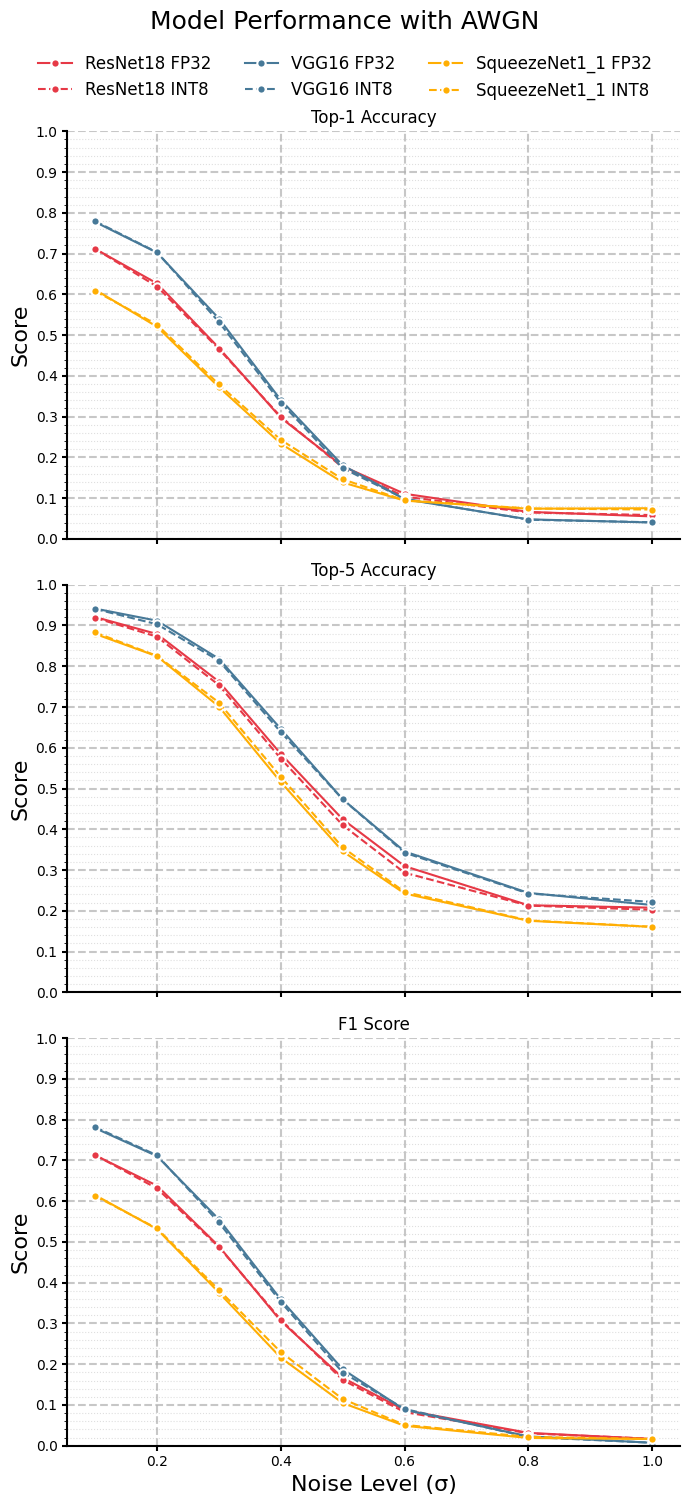

In [ ]:
def create_dataframe(fp_dict, int8_dict, model_name, metric_name):
    fp_data = pd.DataFrame(list(fp_dict.items()), columns=['noise', 'value'])
    fp_data['precision'] = 'FP32'
    fp_data['model'] = model_name
    fp_data['metric'] = metric_name

    int8_data = pd.DataFrame(list(int8_dict.items()), columns=['noise', 'value'])
    int8_data['precision'] = 'INT8'
    int8_data['model'] = model_name
    int8_data['metric'] = metric_name

    return pd.concat([fp_data, int8_data])

# Combine all data
data = pd.concat([
    # ResNet18
    create_dataframe(resnet18_fp_awgn_top1, resnet18_int8_awgn_top1, 'ResNet18', 'Top-1 Accuracy'),
    create_dataframe(resnet18_fp_awgn_top5, resnet18_int8_awgn_top5, 'ResNet18', 'Top-5 Accuracy'),
    create_dataframe(resnet18_fp_awgn_f1, resnet18_int8_awgn_f1, 'ResNet18', 'F1 Score'),
    # VGG16
    create_dataframe(vgg16_fp_awgn_top1, vgg16_int8_awgn_top1, 'VGG16', 'Top-1 Accuracy'),
    create_dataframe(vgg16_fp_awgn_top5, vgg16_int8_awgn_top5, 'VGG16', 'Top-5 Accuracy'),
    create_dataframe(vgg16_fp_awgn_f1, vgg16_int8_awgn_f1, 'VGG16', 'F1 Score'),
    # SqueezeNet
    create_dataframe(squeezenet1_1_fp_awgn_top1, squeezenet1_1_int8_awgn_top1, 'SqueezeNet1_1', 'Top-1 Accuracy'),
    create_dataframe(squeezenet1_1_fp_awgn_top5, squeezenet1_1_int8_awgn_top5, 'SqueezeNet1_1', 'Top-5 Accuracy'),
    create_dataframe(squeezenet1_1_fp_awgn_f1, squeezenet1_1_int8_awgn_f1, 'SqueezeNet1_1', 'F1 Score')
])

# Create the plot with larger size
plt.figure(figsize=(10, 15))  # Adjust figsize for stacked plots
g = sns.FacetGrid(data, col='metric', col_wrap=1, height=5, aspect=1.4)  # col_wrap=1 for vertical stacking

# Define a custom color palette for better visuals
colors = {
    'ResNet18': '#E63946',   # A soft blue
    'VGG16': '#477998',      # A soft green
    'SqueezeNet1_1': '#FFAE03'  # A soft red
}

# Update the plot_lines function to use the new colors
def plot_lines(data, **kwargs):
    ax = plt.gca()
    for model in ['ResNet18', 'VGG16', 'SqueezeNet1_1']:
        for precision in ['FP32', 'INT8']:
            mask = (data['model'] == model) & (data['precision'] == precision)
            linestyle = '-' if precision == 'FP32' else '--'
            sns.lineplot(
                data=data[mask],
                x='noise',
                y='value',
                label=f'{model} {precision}',
                color=colors[model],
                linestyle=linestyle,
                linewidth=1.5,  # Slightly thicker lines
                marker='o',
                markersize=6,   # Medium marker size
                markeredgewidth=1.5,  # Medium marker edge width
                markeredgecolor='white',  # Add contrast with a white edge
                ax=ax  # Specify the current axes
            )

g.map_dataframe(plot_lines)

g.set_axis_labels('Noise Level (σ)', 'Score',fontsize=16)
g.set_titles('{col_name}',fontsize=16)  # Remove "metric=" and keep only the metric name
g.axes[0].set_title('Top-1 Accuracy')  # Custom titles for each subplot
g.axes[1].set_title('Top-5 Accuracy')
g.axes[2].set_title('F1 Score')
handles, labels = g.axes[0].get_legend_handles_labels()
g.fig.legend(
    handles=handles,
    labels=labels,
    loc='upper center',  # Place it at the top center
    bbox_to_anchor=(0.5, 0.98),  # Adjust position below the title
    ncol=3,  # Organize the legend in a single row
    frameon=False,  # Optional: Remove legend box
    fontsize=12
)
g.fig.suptitle('Model Performance with AWGN', y=1, fontsize=18)

# Add grid and customize y-axis for each subplot
for ax in g.axes.flat:
    ax.grid(True, linestyle='--', alpha=0.7, linewidth=1.5)
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.02))
    ax.grid(True, which='minor', linestyle=':', alpha=0.4)
    ax.set_ylim(0, 1.0)
    # Make axis lines and ticks more visible
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.tick_params(width=1.5)

# Adjust layout to prevent legend overlap
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Reserve space for title and legend
output_file = "/content/drive/MyDrive/paperV4/plots/awgn.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')  # High resolution with tight bounding box
plt.show()

In [ ]:
vgg16_fp_horiz_probs[1]

In [87]:
awgn_sigmas = [0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0]
brownian_sigmas = [10,20,30,40,50,60,70,80]
num_streaks = [1,2,3,4,5,6]

def avg_kl(fp_probs, int8_probs):
    average_kl_divergences = {}
    for noise_level in fp_probs:
        kl_divs = []
        for p, q in zip(fp_probs[noise_level], int8_probs[noise_level]):
            p_normalized = np.array(p) / np.nansum(p)
            q_normalized = np.array(q) / np.nansum(q)
            kl_div = entropy(p_normalized, q_normalized)
            kl_divs.append(kl_div)
        average_kl_divergences[noise_level] = np.mean(kl_divs)
    return average_kl_divergences

resnet18_awgn_kl = avg_kl(resnet18_fp_awgn_probs, resnet18_int8_awgn_probs)
vgg16_awgn_kl = avg_kl(vgg16_fp_awgn_probs, vgg16_int8_awgn_probs)
squeezenet1_1_awgn_kl = avg_kl(squeezenet1_1_fp_awgn_probs, squeezenet1_1_int8_awgn_probs)

resnet18_brownian_kl = avg_kl(resnet18_fp_brownian_probs, resnet18_int8_brownian_probs)
vgg16_brownian_kl = avg_kl(vgg16_fp_brownian_probs, vgg16_int8_brownian_probs)
squeezenet1_1_brownian_kl = avg_kl(squeezenet1_1_fp_brownian_probs, squeezenet1_1_int8_brownian_probs)

resnet18_vert_kl = avg_kl(resnet18_fp_vert_probs, resnet18_int8_vert_probs)
vgg16_vert_kl = avg_kl(vgg16_fp_vert_probs, vgg16_int8_vert_probs)
squeezenet1_1_vert_kl = avg_kl(squeezenet1_1_fp_vert_probs, squeezenet1_1_int8_vert_probs)

resnet18_horiz_kl = avg_kl(resnet18_fp_horiz_probs, resnet18_int8_horiz_probs)
vgg16_horiz_kl = avg_kl(vgg16_fp_horiz_probs, vgg16_int8_horiz_probs)
squeezenet1_1_horiz_kl = avg_kl(squeezenet1_1_fp_horiz_probs, squeezenet1_1_int8_horiz_probs)


In [93]:
for sigma in num_streaks:
  resnet18_kl = resnet18_horiz_kl[sigma]
  vgg16_kl = vgg16_horiz_kl[sigma]
  squeezenet1_1_kl = squeezenet1_1_horiz_kl[sigma]

  print(f"{sigma} & {squeezenet1_1_kl:.3f} & {resnet18_kl:.3f} & {vgg16_kl:.3f} \\\\ \\hline ")

1 & 0.014 & 0.009 & 0.021 \\ \hline 
2 & 0.019 & 0.011 & 0.029 \\ \hline 
3 & 0.017 & 0.010 & 0.028 \\ \hline 
4 & 0.019 & 0.011 & 0.032 \\ \hline 
5 & 0.016 & 0.011 & 0.027 \\ \hline 
6 & 0.016 & 0.012 & 0.029 \\ \hline 


In [ ]:
print(squeezenet1_1_horiz_kl, "\n",resnet18_horiz_kl, "\n", vgg16_horiz_kl)

{1: 0.013946280721509623, 2: 0.01944094510698452, 3: 0.017085020478507205, 4: 0.01864680203091067, 5: 0.016241422255737152, 6: 0.01577542815643552} 
 {1: 0.008937136834319938, 2: 0.01062197904492836, 3: 0.01039423697251316, 4: 0.011182377019363731, 5: 0.010743872144070117, 6: 0.012271357250314075} 
 {1: 0.02105255309297559, 2: 0.028817293627429123, 3: 0.027961304999022506, 4: 0.03237350017822018, 5: 0.027418275687534206, 6: 0.028703655713833983}


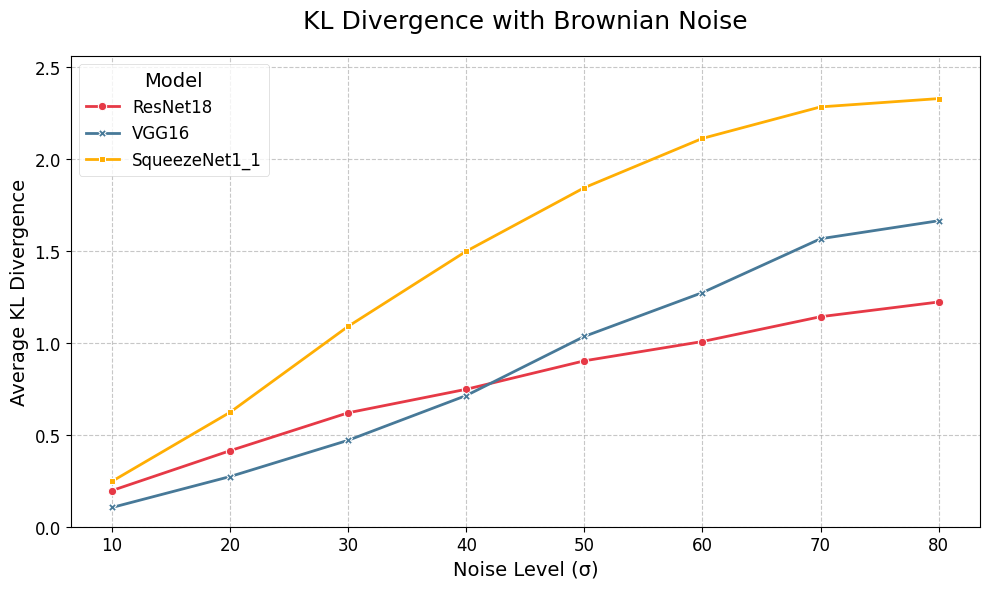

In [ ]:
def plot_kl(resnet18_kl, vgg16_kl, squeezenet1_1_kl):
    # Create a DataFrame for Seaborn
    data = pd.DataFrame([
        {'noise': k, 'value': v, 'model': 'ResNet18'} for k, v in resnet18_kl.items()
    ] + [
        {'noise': k, 'value': v, 'model': 'VGG16'} for k, v in vgg16_kl.items()
    ] + [
        {'noise': k, 'value': v, 'model': 'SqueezeNet1_1'} for k, v in squeezenet1_1_kl.items()
    ])

    # Define a custom color palette for better visuals
    colors = {
        'ResNet18': '#E63946',  # Soft red
        'VGG16': '#477998',     # Soft green
        'SqueezeNet1_1': '#FFAE03'  # Soft orange
    }

    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.lineplot(
        data=data,
        x='noise',
        y='value',
        hue='model',
        palette=colors,
        style='model',
        markers=True,
        dashes=False,
        linewidth=2
    )

    # Customize the plot
    ax.set_title("KL Divergence with Brownian Noise", fontsize=18, pad=20)
    ax.set_xlabel("Noise Level (σ)", fontsize=14)
    ax.set_ylabel("Average KL Divergence", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(visible=True, linestyle='--', alpha=0.7)
    ax.set_ylim(0, max(data['value']) * 1.1)  # Add some padding to the y-axis

    # Enhance the legend
    legend = ax.legend(fontsize=12, title="Model", title_fontsize=14)
    legend.get_frame().set_linewidth(0.5)

    # Tight layout
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/paperV4/plots/brownian_kl.png", dpi=300, bbox_inches='tight')
    plt.show()

plot_kl(resnet18_brownian_kl, vgg16_brownian_kl, squeezenet1_1_brownian_kl)
